<img src='logo_DH.png' align='left' width=35%/>

## Grupo 2
### Integrantes:
* Alejandro Fracchia  
* Eugenia Perotti 
* Gastón Ortiz
* Matias Formica

#### Sección 1:
* [Importacion de librerias y analisis](#importacion)
* [Creacion de variables dummy y variables nuevas](#dummy)
* [Outliers](#outliers)
* [Matriz de features y target](#features)

#### Sección 2:
* [Modelos](#modelos)
    * [Ols con statsmodels](#statsmodels)
    * [Ols con Scikit Learn](#sklearn)
    * [Ridge](#Ridge)
    * [Lasso](#Lasso)
    * [Elastic Net](#elastic)
* [Variables irrelevantes](#variables)
* [Selección de modelo y prueba en testeo](#testeo)

#### Sección 3:
* [Supuestos de Gauss Márkov](#gauss)

<a id="importacion"></a>
## Importacion de librería y análisis del data_set_limpio.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
pd.set_option('display.max_columns', None)
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error ,mean_absolute_error, r2_score ,accuracy_score

Importo el dataset del segundo desafío.

In [2]:
data = pd.read_excel("data_set_limpio.xlsx")

In [3]:
def pct_nulos(df):
    nulos = df.isnull().sum() / df.shape[0]
    return nulos

In [4]:
pct_nulos(data)

Unnamed: 0                    0.000000
operation                     0.000000
property_type                 0.000000
place_name                    0.000200
place_with_parent_names       0.000000
country_name                  0.000000
state_name                    0.000000
geonames_id                   0.114002
lat-lon                       0.414688
lat                           0.414688
lon                           0.414688
price                         0.149908
currency                      0.149916
price_aprox_local_currency    0.149908
price_aprox_usd               0.149908
surface_total_in_m2           0.326573
surface_covered_in_m2         0.157637
price_usd_per_m2              0.423845
price_per_m2                  0.261150
floor                         0.811462
rooms                         0.602399
expenses                      0.878443
properati_url                 0.000000
description                   0.000113
title                         0.000000
image_thumbnail          

In [5]:
data.shape

(114884, 52)

In [ ]:
data.info()

<a id="dummy"></a>
## Dummy y variables nuevas
Primero se crea la variable metros cuadrado al cuadrado

In [6]:
data['M2_cuadrado'] = data.surface_covered_in_m2  ** 2

Hago dummy para ayudar a disferenciar entre grupos, asi podremos usar las variables categoricas en nuestro modelo

In [7]:
#hago dummy del tipo de propiedad y elimino la de ph
tipo_propiedad = pd.get_dummies(data.property_type, drop_first=True)
data = data.join(tipo_propiedad)

In [8]:
# elimino registros que tienen mas de 13 ambientes porque no tienen muchas observaciones 
# y consideramos que un registro que tiene mas de 13 ambientes es considerado un outliers
data = data[(data.ambientes > 0) & (data.ambientes < 14)]
dummy_amb = pd.get_dummies(data.ambientes,drop_first=True)
data = data.join(dummy_amb)

In [9]:
baños = pd.get_dummies(data.Baños,drop_first=True)
data = data.join(baños,rsuffix="baños_")

In [10]:
barrios = pd.get_dummies(data.place_name,drop_first=True)
data = data.join(barrios)

In [11]:

for propiedad in tipo_propiedad.columns:
    for amenitie in ["Pileta","Cochera","Seguridad","Terraza","Patio","Amueblado","Aire_Acondicionado","Estrenar"]:
        data["{amenities}_{tipo}".format(amenities= amenitie,tipo = propiedad)] = data[amenitie] * data[propiedad]

<a id="outliers"></a>
## Outliers
Se eliminan los outliers de nuestra variable target pricem2_covered_usd que se refiere al precio por metro cuadrado cubierto.
Despues se eliminan los outliers en los metros cuadrados cubiertos

Vemos los outliers de nuestro target

In [12]:
data.pricem2_covered_usd.describe()

count    6.697600e+04
mean              inf
std               NaN
min      1.510204e+00
25%      1.408573e+03
50%      2.000000e+03
75%      2.791925e+03
max               inf
Name: pricem2_covered_usd, dtype: float64

Tenemos valores muy chicos y muy grandes por lo que procedemos a eliminarlos.<br>
Se crea una funcion que recibe como parametros el dataframe, la variable que quiero que me quede sin outliers y el metodo por el cual lo voy hacer.
Esta funcio eliminan outliers por provincia. Tiene 3 metodos:
* 2 desviaciones estandar de la media: Ya que el precio seguiria una distribucion normal, el 96% de los datos se encontraria en mas menos dos desviaciones estandar de la media
* Por cuantil: Se eliminan el 2.5% de los datos con precio superior y se elimina el 2.5% de los datos con precio inferior
* Por rango intercuartil: Se eliminan todas las observaciones que se encuentren por fuera de quantil 3 mas 1.5 el rango intercuartil o si se encuentra por debajo del quantil 1 menos 1.5 el rango intercuartil

In [13]:
def outliers_provincias(df,variable,std2="std2"):
    provincias_unique = df.state_name.unique()
    index = []
    if std2 == "std2":
        for i in provincias_unique:
            provincia = df[df.state_name == i]
            lim_sup = provincia[variable].mean() + 2 * provincia[variable].std()
            lim_inf = provincia[variable].mean() - 2 * provincia[variable].std()
            mascara = (provincia[variable] > lim_inf) & (provincia[variable] < lim_sup)
            provincia_limpia = provincia[mascara]
            index += provincia_limpia.index.values.tolist()
    elif std2 == "quantil":
        for i in provincias_unique:
            provincia = df[df.state_name == i]
            lim_sup = df[variable].quantile(0.975)
            lim_inf = df[variable].quantile(0.025)
            mascara = (provincia[variable] > lim_inf) & (provincia[variable] < lim_sup)
            provincia_limpia = provincia[mascara]
            index += provincia_limpia.index.values.tolist()
    elif std2 == "rango intercuantil":
        for i in provincias_unique:
            provincia = df[df.state_name == i]
            q1 = df[variable].quantile(0.25)
            q3 = df[variable].quantile(0.75)
            lim_inf = q1 - (q3 - q1) * 1.5
            lim_sup = (q3 - q1) * 1.5 + q3
            mascara = (provincia[variable] > lim_inf) & (provincia[variable] < lim_sup) 
            provincia_limpia = provincia[mascara]
            index += provincia_limpia.index.values.tolist()
    else:
        return "error"
    df_limpio = df.loc[sorted(index)]
    return df_limpio

Aplicamos la función al precio por metro cuadrado cubierto.
Se aplican los 3 criterios para definir outliers

In [14]:
data_price_m2 = outliers_provincias(data,"pricem2_covered_usd")
data_price_m2_1 = outliers_provincias(data,"pricem2_covered_usd",std2="quantil")
data_price_m2_2 = outliers_provincias(data,"pricem2_covered_usd",std2="rango intercuantil")

In [15]:
data_price_m2.shape,data_price_m2_1.shape,data_price_m2_2.shape

((44410, 1077), (63619, 1077), (62857, 1077))

In [16]:
print("Descripción del precio por metro cuadrado cubierto cuando eliminamos outliers por 2 mas menos DESVIACION ESTANDAR",data_price_m2.pricem2_covered_usd.describe())
print("Descripción del precio por metro cuadrado cubierto cuando eliminamos outliers por 2.5% SUPERIOR E INFERIOR",data_price_m2_1.pricem2_covered_usd.describe())
print("Descripción del precio por metro cuadrado cubierto cuando elimino outliers por el RANGO INTERCUARTIL",data_price_m2_2.pricem2_covered_usd.describe())

Descripción del precio por metro cuadrado cubierto cuando eliminamos outliers por 2 mas menos DESVIACION ESTANDAR count    44410.000000
mean      2087.658813
std       2617.475289
min          1.510204
25%       1222.222222
50%       1670.761667
75%       2245.531281
max      69000.000000
Name: pricem2_covered_usd, dtype: float64
Descripción del precio por metro cuadrado cubierto cuando eliminamos outliers por 2.5% SUPERIOR E INFERIOR count    63619.000000
mean      2255.466549
std       1252.229968
min        620.219471
25%       1440.677966
50%       2000.000000
75%       2735.781671
max      11450.000000
Name: pricem2_covered_usd, dtype: float64
Descripción del precio por metro cuadrado cubierto cuando elimino outliers por el RANGO INTERCUARTIL count    62857.000000
mean      2039.852677
std        901.869160
min          1.510204
25%       1375.000000
50%       1919.230769
75%       2600.000000
max       4866.666667
Name: pricem2_covered_usd, dtype: float64


Cuando el tengo en cuenta el **rango intercuartil** para filtar outliers da mejores resultado. Para terminar de eliminar outlier vamos a eliminar los registros que esten por fuera de la media menos 2 desvios estandar

In [17]:
valor_min = data_price_m2_2.pricem2_covered_usd.mean() - 2* data_price_m2_2.pricem2_covered_usd.std()
data_price_m2_2 = data_price_m2_2[data_price_m2_2.pricem2_covered_usd > valor_min]
data_price_m2_2.shape

(62612, 1077)

Limpiando outliers nos quedan mas de 60 mil registros si usamos el **rango intercuantil** para definir outliers <br>
Vamos a usar el metodo del **rango intercuartil** porque es el que mejor filtra los outliers.<br>
Se eliminan las columnas del data set que no vamos a tener en cuenta

In [18]:
# Nos quedamos con las culumnas relevantes
columnas = ['Unnamed: 0', 'operation', 'property_type', 'place_name','place_with_parent_names', 'country_name', 'state_name', 'geonames_id',\
       'lat-lon', 'lat', 'lon', 'price', 'currency','price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',\
       'price_usd_per_m2', 'price_per_m2', 'floor','rooms', 'expenses', 'properati_url', 'description', 'title','image_thumbnail','ambientes',\
            'lat-lon_latitud', 'pricem2_total_usd','price_dolar','price_m2_dolar','lat-lon_longitud','Baños']
data_clean_m2 = data_price_m2_2.drop(columns = columnas)

Ahora vamos a ver la distribucion nuestra **variable dependiente o target.**<br>
Vemos que no siguia una distribucion normal antes de eliminar outliers

Me fijo si nuestro target esta sesgado 72.05490735593716


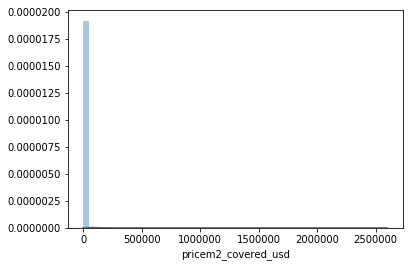

In [19]:
grafico_antes = data[(data.pricem2_covered_usd > 0) & (data.pricem2_covered_usd < np.inf)].pricem2_covered_usd
print("Me fijo si nuestro target esta sesgado",grafico_antes.skew())
sns.distplot(grafico_antes)

Se ver que nuestro target esta repleto de outliers, esta muy sesgado y no sigue una distribución normal.<br>
Ahora se ve como queda nuestro target despues de eliminar outliers.

Me fijo si nuestro target esta sesgado 0.610637386248729


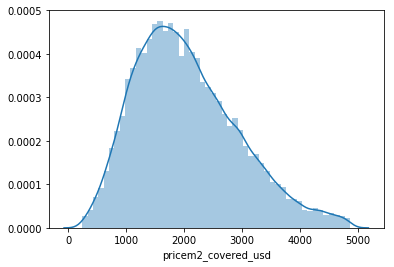

In [20]:
print("Me fijo si nuestro target esta sesgado",data_clean_m2.pricem2_covered_usd.skew())
sns.distplot(data_clean_m2.pricem2_covered_usd)

Sigue una distribucion normal y ahora el sesgo es pequeño<br>
Se prueba si aplicando logaritmo se puede arreglar aun mas nuestro target.

Me fijo si nuestro target esta sesgado -0.6020671086950817


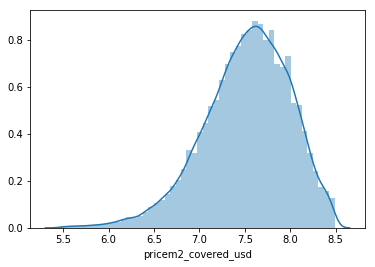

In [21]:
print("Me fijo si nuestro target esta sesgado",np.log(data_clean_m2.pricem2_covered_usd).skew())
sns.distplot(np.log(data_clean_m2.pricem2_covered_usd))

Se nota que ahora esta sesgado para la izquierda, tiene un sesgo negativo. Por lo que aplicar logaritmo no mejora la distribucion<br>
Nos quedamos con **nuestro target con los outliers eliminados**

Ahora vemos la distribucion de los **metros cuadrado cubiertos** y si tiene outliers

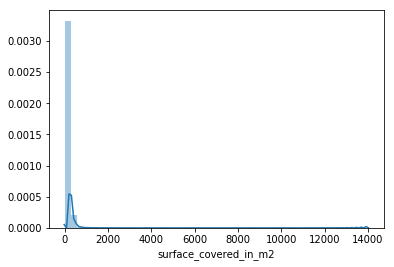

In [22]:
sns.distplot(data_clean_m2.surface_covered_in_m2)

In [23]:
data_clean_m2.surface_covered_in_m2.describe()

count    62612.000000
mean       120.730406
std        205.888389
min          8.000000
25%         47.000000
50%         75.000000
75%        145.000000
max      14000.000000
Name: surface_covered_in_m2, dtype: float64

Vemos que los **metros cuadrado cubiertos** tienen outliers por lo que los vamos a eliminar.<br>
Se eliminan el 1% de los datos inferiores y superiores

In [24]:
# Nos quedamos con los datos de los registros que se encuentran entre el cuantil 0.01 y 0.99
mascara_q01 = data_clean_m2.surface_covered_in_m2 >= data_clean_m2.surface_covered_in_m2.quantile(0.01)
mascara_q99 = data_clean_m2.surface_covered_in_m2 <= data_clean_m2.surface_covered_in_m2.quantile(0.98)
data_clean_m2 = data_clean_m2[mascara_q01 & mascara_q99]
data_clean_m2.surface_covered_in_m2.describe()

count    60869.000000
mean       106.717511
std         83.705299
min         22.000000
25%         47.000000
50%         74.000000
75%        140.000000
max        450.000000
Name: surface_covered_in_m2, dtype: float64

1.6347452790436565


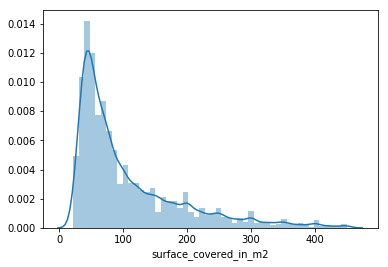

In [25]:
print(data_clean_m2.surface_covered_in_m2.skew())
sns.distplot(data_clean_m2.surface_covered_in_m2)

Se nota una distribución sesgada hacia la derecha, por lo qeu tienen un sesgo positivo.

<a id="features"></a>
## Se crea nuestra matriz de features y nuestro target.
Ademas se dividen los datOS en entrenamiento y testeo

In [26]:
# Creo la variable de las features y le agrego la feature m2 al cuadrado
X = data_clean_m2.drop(columns=['pricem2_covered_usd'])
y = data_clean_m2.pricem2_covered_usd
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 52)
print("Cantidad de Observaciones:\n", X.shape[0])
print("Cantidad de Features:\n", X.columns.shape)

Cantidad de Observaciones:
 60869
Cantidad de Features:
 (1044,)


Verificamos que no haya nulos en las features y en el target.

In [27]:
nulos_X = pct_nulos(X)
print("Variables nulas en X:",nulos_X[nulos_X > 0])

Variables nulas en X: Series([], dtype: float64)


<a id="modelos"></a>
## Modelos
En todos los modelos que aplicamos se usa los datos de entrenamientos. Primero se verá cual es el modelo que mejor performance tiene y luego se eliminan las variables irrelevantes.<br>
Una vez elegido el modelo y las variables relevantes se determina cuan bien predice nuestro modelo en testeo<br>

<a id="statsmodels"></a>
### Minimos cuadrados ordinarios con statsmodels

Se crea una funcion que recibe un data frame con todas las features y una serie con los target.<br>
Esta función hace un train,test, split con los datos y hace la regresion lineal con statsmodel y despues los prueba en los de testeo generados.

In [28]:
def linear_regression(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=52)
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)
    modelo = sm.OLS(y_train,X_train).fit()
    prediccion_train = modelo.predict(X_train)
    prediccion = modelo.predict(X_test)
    print("MSE:",mean_squared_error(y_test,prediccion))
    print("MSE:",np.sqrt(mean_squared_error(y_test,prediccion)))
    print("MAE:",mean_absolute_error(y_test,prediccion))
    print("R2 de entrenamiento:",r2_score(y_train,prediccion_train))
    print("R2 de testeo:",r2_score(y_test,prediccion))
    return modelo

In [29]:
modelo_sm = linear_regression(X_train,y_train)

MSE: 287908.41254216485
MSE: 536.5709762390851
MAE: 402.48417695043395
R2 de entrenamiento: 0.6411404142983523
R2 de testeo: 0.6368374704797568


In [30]:
modelo_sm.summary()

C:\ProgramData\Anaconda3\envs\dhdsblend\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\ProgramData\Anaconda3\envs\dhdsblend\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\envs\dhdsblend\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\envs\dhdsblend\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     pricem2_covered_usd   R-squared:                       0.641
Model:                             OLS   Adj. R-squared:                  0.633
Method:                  Least Squares   F-statistic:                     83.50
Date:                 Fri, 10 Jul 2020   Prob (F-statistic):               0.00
Time:                         20:03:07   Log-Likelihood:            -2.9967e+05
No. Observations:                38956   AIC:                         6.010e+05
Df Residuals:                    38139   BIC:                         6.080e+05
Df Model:                          816                                         
Covariance Type:             nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                    2332.8997    204.467     11.410      0.000    1932.140    2733.660
surface_covered_in_m2                      -4.7165      0.163    -28.981      0.000      -5.035      -4.397
Parrilla                                   42.4254      7.109      5.968      0.000      28.492      56.359
Quincho                                    -3.4764      8.232     -0.422      0.673     -19.611      12.658
Balcon                                     58.8000      6.564      8.959      0.000      45.935      71.665
Patio                                       7.0803     23.786      0.298      0.766     -39.542      53.702
Lavadero                                  -14.8823      6.544     -2.274      0.023     -27.710      -2.055
Baulera                                    49.0461      9.713      5.049      0.000      30.008      68.084
Gimnasio                                  156.2923     13.125     11.908      0.000     130.567     182.018
Seguridad                                 116.9658     80.995      1.444      0.149     -41.787     275.719
Barrio_Cerrado                             86.9211     19.178      4.532      0.000      49.332     124.511
Calefaccion                                40.3263      8.067      4.999      0.000      24.515      56.137
Terraza                                     5.0225     23.722      0.212      0.832     -41.473      51.518
Sauna                                     125.5157     18.700      6.712      0.000      88.863     162.168
Pileta                                    194.0290     54.211      3.579      0.000      87.773     300.285
Cochera                                    77.3006     26.710      2.894      0.004      24.948     129.653
Jacuzzi                                   225.9384     18.207     12.409      0.000     190.251     261.626
Aire_Acondicionado                         73.6309     50.116      1.469      0.142     -24.599     171.861
Amueblado                                 120.5225    221.910      0.543      0.587    -314.428     555.473
Estrenar                                  185.5943     53.416      3.475      0.001      80.897     290.291
M2_cuadrado                                 0.0076      0.000     20.305      0.000       0.007       0.008
apartment                                 274.2263     23.293     11.773      0.000     228.571     319.882
house                                      90.8669     25.425      3.574      0.000      41.033     140.701
store                                     435.0275     32.113     13.547      0.000     372.085     497.970
2.0                                        54.0921      9.546      5.667      0.000      35.382      72.802
3.0                                        74.84

### Scikit Learn

Ahora mediante **Scikit Learn** se crea una funcion que recibe como primer parametro los features, como segundo el target. Como parametros opcionales tenemos los alpha, si es un modelo normalizado, el tipo de modelo y las particiones para el cross validation.<br>
Primero esta función hace una divición de los datos en entrenamiento y testo.Luego aplica el modelo elegido y ve la permance en testeo.

In [31]:
def modelos(X, y, alpha=[0,1,10],normalizado = False, tipo= "Linear", folds=3):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=52)
    if tipo == "Linear":
        cross_val = cross_val_score(estimator = linear_model.LinearRegression(),X = X_train,y = y_train, cv=folds)
        modelo = linear_model.LinearRegression()
        modelo.fit(X_train,y_train)
        r2_train = modelo.score(X_train,y_train)
        r2_test = modelo.score(X_test,y_test)
        prediccion_train = modelo.predict(X_train)
        prediccion = modelo.predict(X_test)
        print("MSE:",mean_squared_error(y_test,prediccion))
        print("RMSE:",np.sqrt(mean_squared_error(y_test,prediccion)))
        print("MAE:",mean_absolute_error(y_test,prediccion))
        return print("Validacion cruzada:",cross_val,"\nR2 medio:",cross_val.mean(),"\nR2 de entrenamiento:",r2_train,"\nR2 de testeo:",r2_test)
    elif tipo == "Lasso":
        modelo =  linear_model.LassoCV(alphas = np.linspace(alpha[0],alpha[1],alpha[2]), cv=folds,normalize = normalizado,n_jobs=-1)
        modelo.fit(X_train,y_train)
        prediccion_train = modelo.predict(X_train)
        prediccion = modelo.predict(X_test)
        betas = dict(zip(X.columns,modelo.coef_))
        serie_betas = pd.Series(betas)
        betas_cero = serie_betas[serie_betas == 0]
        alpha_opt = modelo.alpha_
        print("Variables con beta igual a 0:",(modelo.coef_ == 0).sum())
        print("Score del modelo en entrenamiento:",modelo.score(X_train,y_train))
        print("Score del modelo en testeo:",modelo.score(X_test,y_test))
        print("MSE:",mean_squared_error(y_test,prediccion))
        print("RMSE:",np.sqrt(mean_squared_error(y_test,prediccion)))
        print("MAE:",mean_absolute_error(y_test,prediccion))
        print("\nAlpha elegido:",modelo.alpha_)
        return modelo, alpha_opt, betas_cero
    else: 
        modelo = linear_model.RidgeCV(np.linspace(alpha[0],alpha[1],alpha[2]), cv=folds,normalize = normalizado)
        modelo.fit(X_train,y_train)
        prediccion_train = modelo.predict(X_train)
        prediccion = modelo.predict(X_test)
        print("Variables con beta igual a 0:",(modelo.coef_ == 0).sum())
        print("MSE:",mean_squared_error(y_test,prediccion))
        print("RMSE:",np.sqrt(mean_squared_error(y_test,prediccion)))
        print("MAE:",mean_absolute_error(y_test,prediccion))
        return print("Score del modelo en entrenamiento:",modelo.score(X_train,y_train),"\nScore del modelo en testeo:",modelo.score(X_test,y_test),"\nAlpha elegido:",modelo.alpha_)

<a id="sklearn"></a>
### MCO con Scikit Learn
Empezamos con un modelo lineal simple con minimos cuadrados ordinarios.

In [32]:
# Ahora agregamos los barrios y provincias a las features
modelos(X_train,y_train)

MSE: 287908.4125431212
RMSE: 536.5709762399763
MAE: 402.4841769552245
Validacion cruzada: [0.61548091 0.62312552 0.61883978] 
R2 medio: 0.6191487358012869 
R2 de entrenamiento: 0.6411404142983524 
R2 de testeo: 0.6368374704785504


<a id="ridge"></a>
#### Ridge
Se aplica la funcion para regresión de tipo **Ridge**

In [33]:
#Con toda la features
modelos(X_train,y_train,alpha=[0.01,1,10],tipo="Ridge",normalizado=True)

Variables con beta igual a 0: 228
MSE: 286689.3107845821
RMSE: 535.4337594741128
MAE: 401.94207277539476
Score del modelo en entrenamiento: 0.6404314529911252 
Score del modelo en testeo: 0.6383752236635456 
Alpha elegido: 0.01


<a id="lasso"></a>
#### Lasso
Se aplica la funcion para regresión de tipo **Lasso.**
Con Lasso obtenemos las variables irrelevantes del modelo para poder eliminarlas despues.

In [34]:
# Ahora agregamos los barrios y provincias a las features
lasso, alpha, betas0 = modelos(X_train,y_train,alpha=[0.01,0.1,10],tipo="Lasso",normalizado=True)

Variables con beta igual a 0: 429
Score del modelo en entrenamiento: 0.6368337901613272
Score del modelo en testeo: 0.6378066168169066
MSE: 287140.091581799
RMSE: 535.8545433061093
MAE: 402.9405823259937

Alpha elegido: 0.01


<a id="elastic"></a>
#### ElasticNET
Se hace una regresion con ElasticNet para ver si logramos alguna mejora

In [96]:
params = {'alpha':[0.001,0.005,0.008]}

ridge = linear_model.ElasticNet()
folds = KFold(n_splits=3,shuffle=True,random_state=101)

model_cv = GridSearchCV(estimator = ridge,
                       param_grid = params,
                       scoring = 'r2',
                       cv = folds,
                       return_train_score = True,
                       verbose =1)

model_cv.fit(X_train,y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [ ]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

### Comentarios de los resultados:
Se aprecia que minimos cuadrados ordinarios, rigde, lasso y elastic net tienen resultados parecidos.<br>
Se ve que tanto rigde, lasso y elastic net eligen un coeficiente alpha muy chico, por lo que no penalizan mucho los beta, esto quiere decir que se parece cada vez mas a minimos cuadrados ordinarios a medida que el alpha se achica.<br>
Se elige al metodo **Minimos Cuadrados Ordinarios** como el mejor y el que vamos a utilizar mas adelante para los testeos.

<a id="variables"></a>
## Se eliminan las features irrelevantes
Primero antes de probar el modelo en los datos de testeo se eliminan las variable irrelevantes de acuerdo a las que elimina la regresion lasso.<br> Se procede a eliminar esas variables para lograr una mejor performance sin que el modelo pierda poder de predicción.

Se eliminan las variables innecesarias 

In [35]:
X_train_listo = X_train.drop(columns=list(betas0.index.values))
X_test_listo = X_test.drop(columns=list(betas0.index.values))

Se corren de vuelta las regresiónes

In [36]:
modelos(X_train_listo,y_train)

MSE: 285165.2165360116
RMSE: 534.0086296456375
MAE: 400.74273678235795
Validacion cruzada: [0.61957375 0.62976579 0.63050457] 
R2 medio: 0.6266147041393794 
R2 de entrenamiento: 0.6403796242815729 
R2 de testeo: 0.6402976889282834


In [37]:
modelos(X_train_listo,y_train,alpha=[0.01,1,10],tipo="Ridge",normalizado=True)

Variables con beta igual a 0: 0
MSE: 286191.4425035184
RMSE: 534.968636934464
MAE: 401.8037211027756
Score del modelo en entrenamiento: 0.6396842279244326 
Score del modelo en testeo: 0.6390032258213237 
Alpha elegido: 0.01


In [38]:
modelos(X_train_listo,y_train,alpha=[0.01,0.1,10],tipo="Lasso",normalizado=True)

Variables con beta igual a 0: 0
Score del modelo en entrenamiento: 0.6368322575919755
Score del modelo en testeo: 0.6378049843224972
MSE: 287141.3857926156
RMSE: 535.8557509186736
MAE: 402.9417928928141

Alpha elegido: 0.01


(LassoCV(alphas=array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]),
         copy_X=True, cv=3, eps=0.001, fit_intercept=True, max_iter=1000,
         n_alphas=100, n_jobs=-1, normalize=True, positive=False,
         precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
         verbose=False),
 0.01,
 Series([], dtype: float64))

**Se puede apreciar que no se pierde poder de prediccion en el modelo. De vuelta el modelo que mejor predice es por el metodo de minimos cuadrado ordinarios**

<a id="testeo"></a>
## Prediccion en testo
Se utilizan los datos de testeo para ver la performance del modelo.

In [39]:
modelo_elegido = linear_model.LinearRegression()
modelo_elegido.fit(X_train_listo,y_train)
prediccion_train = modelo_elegido.predict(X_train_listo)
print("R2 de entrenamiento",r2_score(y_train,prediccion_train))
prediccion_test = modelo_elegido.predict(X_test_listo)
print("R2 de testeo",r2_score(y_test,prediccion_test))
print("MSE:",mean_squared_error(y_test,prediccion_test))
print("RMSE:",np.sqrt(mean_squared_error(y_test,prediccion_test)))
print("MAE:",mean_absolute_error(y_test,prediccion_test))

R2 de entrenamiento 0.6411679559621696
R2 de testeo 0.6394891247298042
MSE: 285256.15546352783
RMSE: 534.0937702908805
MAE: 399.2462509835982


El modelo tiene un R2 de testeo de casi 0.64, esto quiere decir que captura el 64% de la variabilidad del precio por metro cuadrado cubierto.<br>
La raiz cuadrada del error cuadratico medio(RMSE) es igual a 534, esto significa que en promedio el error de predicción es de 534 dolares para el precio por metro cuadrado.<br>
Si vemos el error absoluto medio(MAE) es igual a 399, esto tambien significa que en promedio el error de predicción fue de 399 dolares para el precio por metro cuadrado.<br>
La diferencia entre el RMSE y el MAE se da porque el RMSE penaliza mas los errores de predicción grandes, ya que al elevar al cuadrado los errores aumenta mas si hay errores muy grandes.

### Graficos de regresión
Se realizan unos graficos para ver los valores predicho en entrenamiento y testeo

R2 de entrenamiento 0.64000597922815


[Text(0,0.5,'Observados'), Text(0.5,0,'Predichos')]

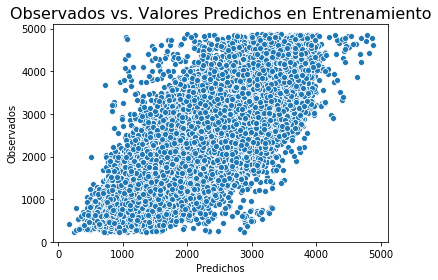

In [78]:
print("R2 de entrenamiento",r2_score(y_train,prediccion_train))
fig, ax = plt.subplots(1,1)
sns.scatterplot(x=prediccion_train, y=y_train, ax=ax)
ax.set_title('Observados vs. Valores Predichos en Entrenamiento', fontsize=16)
ax.set(xlabel='Predichos', ylabel='Observados')

R2 de testeo 0.6427475042351312


[Text(0,0.5,'Observados'), Text(0.5,0,'Predichos')]

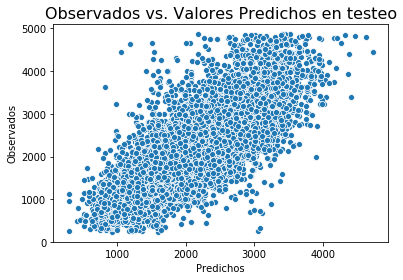

In [79]:
print("R2 de testeo",r2_score(y_test,prediccion_test))
fig, ax = plt.subplots(1,1)
sns.scatterplot(x=prediccion_test, y=y_test, ax=ax)
ax.set_title('Observados vs. Valores Predichos en testeo', fontsize=16)
ax.set(xlabel='Predichos', ylabel='Observados')

<a id="gauss"></a>
## Compruebo si se cumplen los supuestos de gauss markov 
Una vez elegido el modelo, se procede a verificar los supuestos de gauss markov.

In [80]:
X_constant_train = sm.add_constant(X_train_listo)
X_constant_test = sm.add_constant(X_test_listo)
lin_reg = sm.OLS(y_train,X_constant_train).fit()
lin_reg.summary()

In [ ]:
X.shape

#### Linealidad del modelo

Para detectar la falta de linealidad, se pueden inspeccionar gráficas de valores observados frente a valores pronosticados o residuales frente a valores predichos. El resultado deseado es que los puntos se distribuyen simétricamente alrededor de una línea diagonal en la primera gráfica o alrededor de una línea horizontal en la última. En ambos casos con una varianza aproximadamente constante.

In [744]:
def linearity_test(model, y):
    '''
    funcion para visualizar e identificar supuestos de linealidad sobre la regression lineal
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2)
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observados vs. Valores Predichos', fontsize=16)
    ax[0].set(xlabel='Predichos', ylabel='Observados')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residos vs. Valores Predichos', fontsize=16)
    ax[1].set(xlabel='Predichos', ylabel='Residuos')

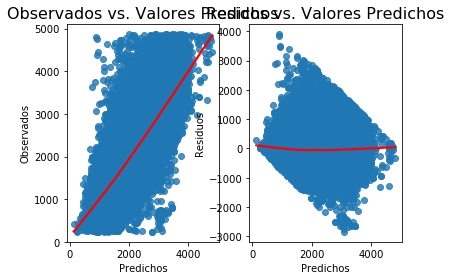

In [745]:
linearity_test(lin_reg, y_train)    

<p>Se observa en el primer grafico que hay una tendencia lineal entre los valores observados y predichos.</p>
<p>En el segundo grafico, los errores son en promedio igual a 0. Por eso la linera horizotal roja es casi recta en 0 en el eje y</p>
<p>Con todo esto podemos decir que el supuesto de linealidad del modelo se cumple.</p>

#### Esperanza de los residuos igual a cero.

In [746]:
lin_reg.resid.mean()

-8.501245355685684e-11

La esperanza de los residuos del modelo es igual a 0. Por lo que este supuesto se cumple

#### Sin Multicolinealidad perfecta
Para detectar multicolinealidad poder utilizar el factor de inflación de varianza (VIF). Sin entrar en demasiados detalles, la interpretación de VIF es la siguiente: la raíz cuadrada de un VIF de una variable dada muestra cuánto más grande es el error estándar, en comparación con lo que sería si ese predictor no estuviera correlacionado con las otras características del modelo . Si no se correlacionan características, todos los valores para VIF serán 1. Si el valor de VIF esta sobre 10 quiere decir que hay multicolinealidad entre variables.<br>
Utilizamos todas las features menos los que representan barrios, ya que demanda mucho tiempo de procesamiento

In [760]:
X_constant.columns[0:24]

Index([                'const', 'surface_covered_in_m2',
                      'pileta',               'cochera',
                    'Parrilla',                'Balcon',
                       'Patio',              'Lavadero',
                     'Baulera',              'Gimnasio',
                 'M2_cuadrado',             'apartment',
                       'house',                 'store',
                         '2.0',                   '3.0',
                         '4.0',                     6.0,
                           8.0,                     9.0,
                          10.0,                    11.0,
                     '3baños_',               '4baños_'],
      dtype='object')

In [114]:
X_vif = X_constant_train.iloc[:,0:24]

In [762]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=X_vif.columns[1:]).T

,surface_covered_in_m2,pileta,cochera,Parrilla,Balcon,Patio,Lavadero,Baulera,Gimnasio,M2_cuadrado,apartment,house,store,2.0,3.0,4.0,6.0,8.0,9.0,10.0,11.0,3baños_,4baños_
vif,19.342497,1.452561,1.169112,1.280611,1.285871,1.215317,1.206491,1.121819,1.305079,14.80278,5.272789,5.294379,1.663398,1.804609,1.878185,1.711047,1.128582,1.028823,1.011112,1.015338,1.004687,1.030644,1.02535


<p>Se puede ver que las dos variables que presentan colinealidad son surfece_covered_in_m2 y M2_cuadrado ya que su vif es mayor a 10.</p>
<p>Estas variables se correlacionan porque M2_cuadrado es una transformación cuadratica de la otra variable.</p>
<p>Si eliminamos M2_cuadrado se deberia eliminar la multicolinealidad</p>

In [ ]:
# Ahora pruebo sacando el termino cuadratico 
X_vif1 = X_vif.drop(columns=["M2_cuadrado"])

In [768]:
vif = [variance_inflation_factor(X_vif1.values, i) for i in range(X_vif1.shape[1])]

In [770]:
pd.DataFrame({'vif': vif[1:]}, index=X_vif1.columns[1:]).T

,surface_covered_in_m2,pileta,cochera,Parrilla,Balcon,Patio,Lavadero,Baulera,Gimnasio,apartment,house,store,2.0,3.0,4.0,6.0,8.0,9.0,10.0,11.0,3baños_,4baños_
vif,2.126467,1.447559,1.163335,1.278308,1.285788,1.214455,1.188773,1.115267,1.304435,5.233181,5.182792,1.657646,1.804608,1.815301,1.618822,1.121129,1.027825,1.010606,1.015296,1.004428,1.028632,1.024242


#### Homocedasticidad de residuos

C:\Users\usuario\anaconda3\envs\dhdsblend\lib\site-packages\statsmodels\stats\outliers_influence.py:693: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)



 Breusch-Pagan test ----
                                     value
Lagrange multiplier statistic  3623.852999
p-value                           0.000000
f-value                           6.577550
f p-value                         0.000000

 Goldfeld-Quandt test ----
                value
F statistic  1.013647
p-value      0.147647

 Residuals plots ----


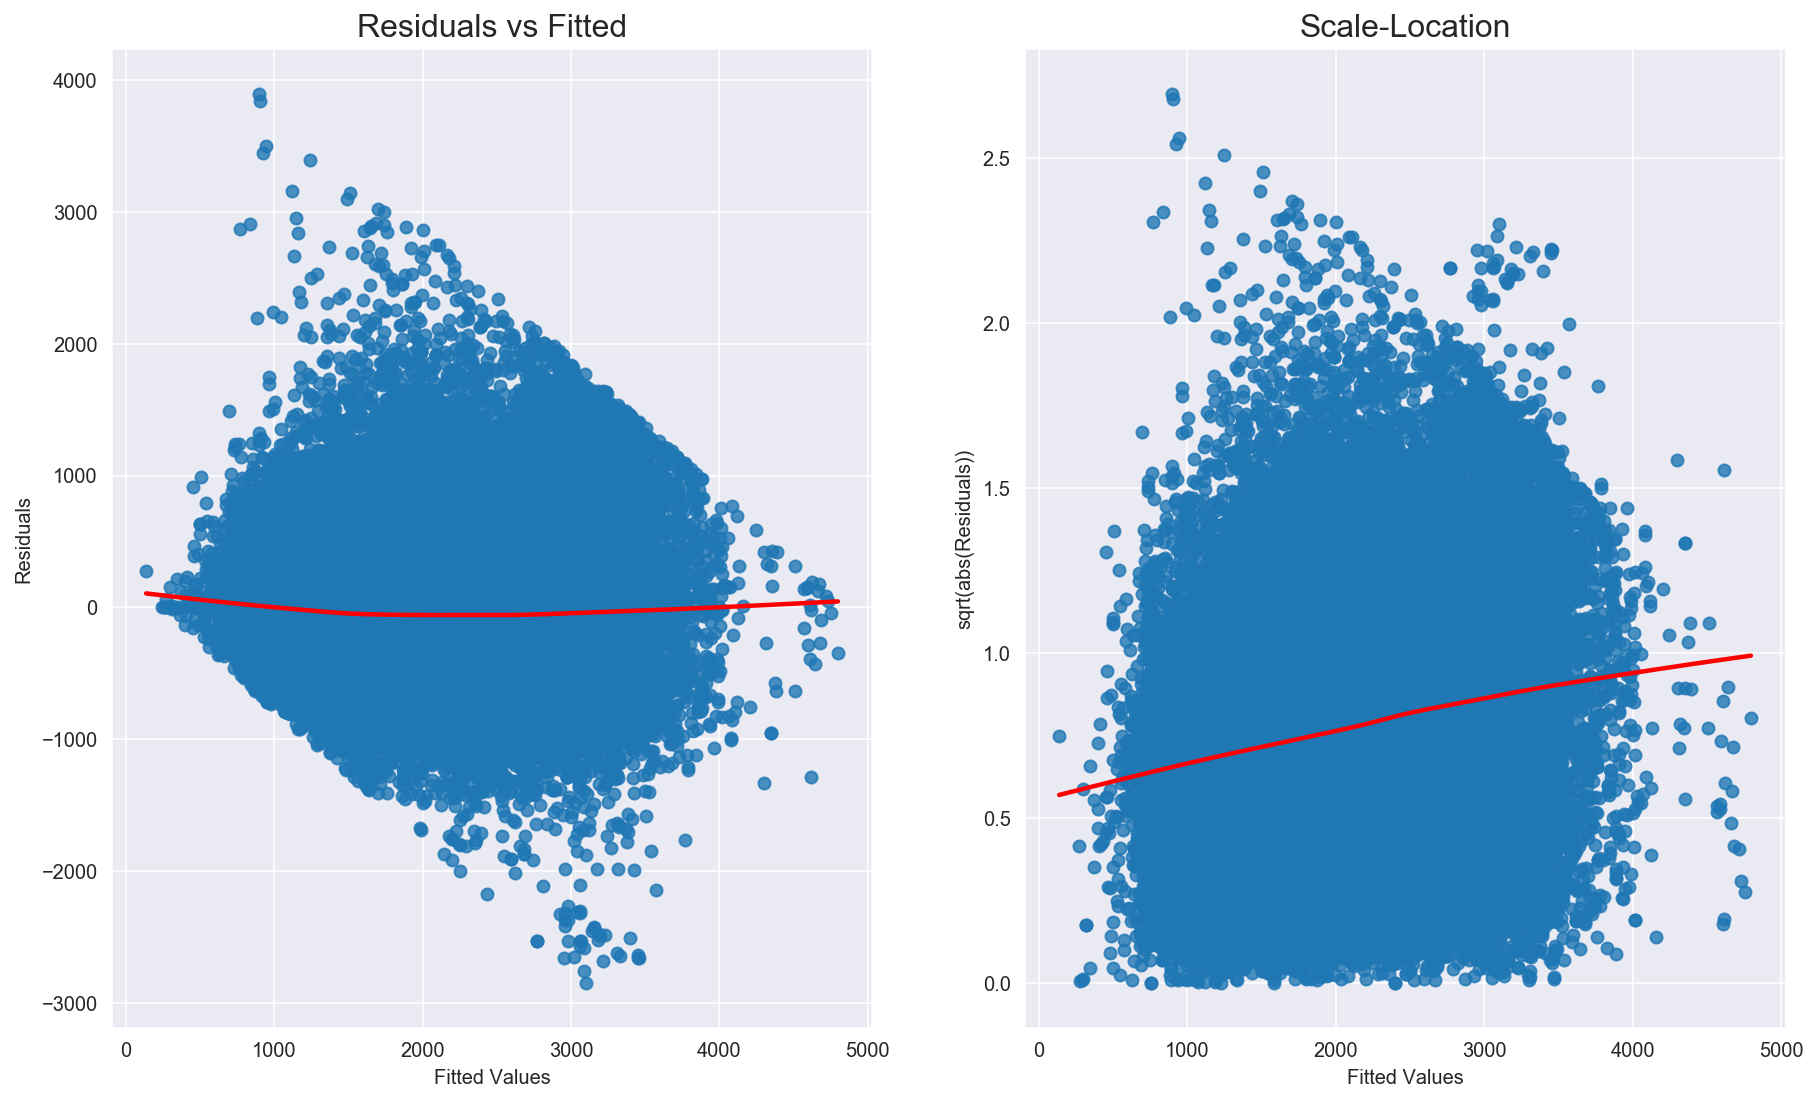

In [747]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import statsmodels.stats.api as sms
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def homoscedasticity_test(model):
    '''
    Function for testing the homoscedasticity of residuals in a linear regression model.
    It plots residuals and standardized residuals vs. fitted values and runs Breusch-Pagan and Goldfeld-Quandt tests.
    
    Args:
    * model - fitted OLS model from statsmodels
    '''
    fitted_vals = model.predict()
    resids = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal

    fig, ax = plt.subplots(1,2)

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Scale-Location', fontsize=16)
    ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')

    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, model.model.exog), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, model.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])

    print('\n Breusch-Pagan test ----')
    print(bp_test)
    print('\n Goldfeld-Quandt test ----')
    print(gq_test)
    print('\n Residuals plots ----')

homoscedasticity_test(lin_reg)

<p> En el primer grafico se puede ver que la variabilidad de los errores es chica para valores predichos bajos, muy grande para valores predichos medios y se comienza a achicar para valores predichos grandes. Esto quiere decir que la varianza de los errores no es constante, hay heterocedasticidad.</p>
<p>El p-value de la prueba Breusch-Pagan es muy chico por lo que podemos concluir que el modelo presenta heterocedasticidad.</p>

#### Autocorrelación

Para investigar si la autocorrelación está presente, utilizo gráficos ACF (función de autocorrelación) y la prueba de Durbin-Watson. En el primer caso, queremos ver si el valor de ACF es significativo para cualquier retraso (en caso de que no haya datos de series temporales, se utiliza el número de fila). Al llamar a la función, indicamos el nivel de significación en el que estamos interesados y el área crítica se traza en el gráfico. Las correlaciones significativas se encuentran fuera de esa área.
Algunas notas sobre la prueba de Durbin-Watson:
* El estadistico de prueba siempre tiene un valor entre 0 y 4
* El valor de 2 significa que no hay autocorrelación en la muestra
* Valores <2 indican autocorrelación positiva, valores > 2 negativo uno.

C:\Users\usuario\anaconda3\envs\dhdsblend\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


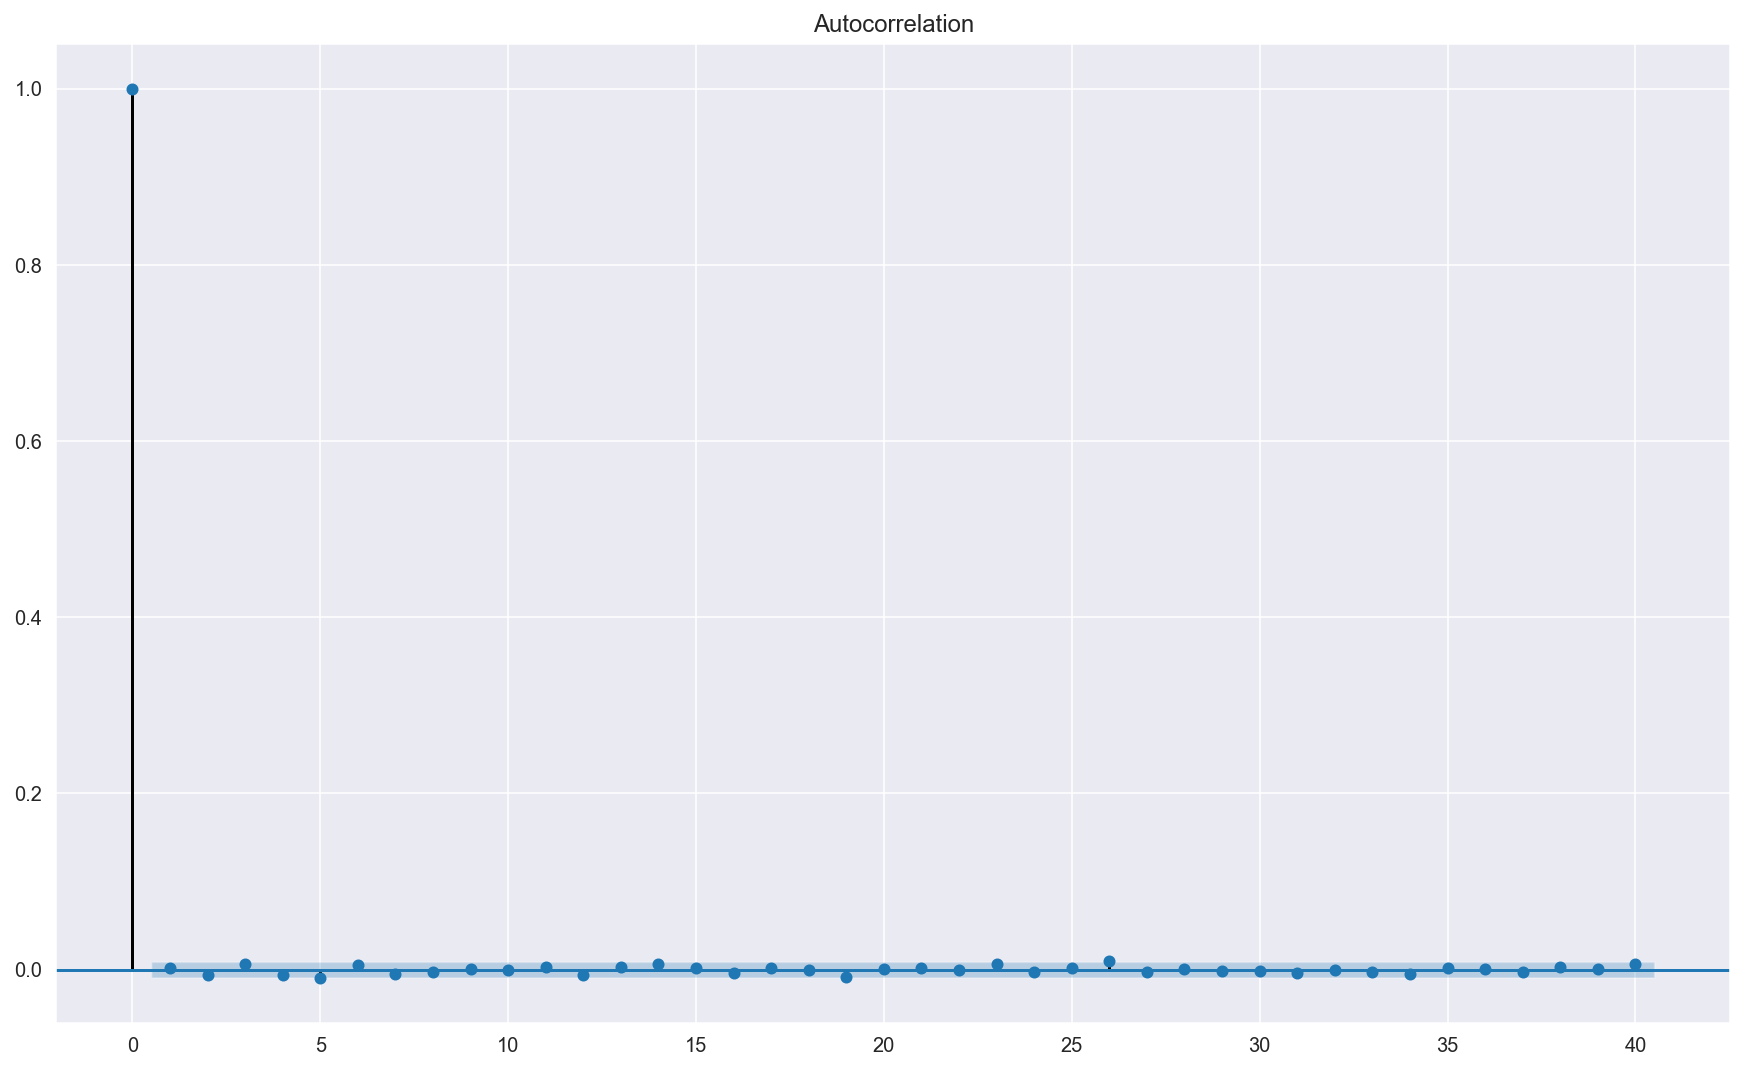

In [748]:
import statsmodels.tsa.api as smt

acf = smt.graphics.plot_acf(lin_reg.resid, lags=40 , alpha=0.05)
acf.show()

En el grafico s ve que no hay autocorrelación. Ya que no hay ninguna correlación significativa por fuera del area critica pintada de azul. Por lo que los residuales no tienen autocorelación serial.<br>
Ademas la prueba de Durbin-Watson es cercana a 2, indicando de vuelta que no hay autocorrelación.<br>
Esto era de esperarse ya que en el data set las muestras son independientes, es un corte transversal, no una serie de tiempo.

#### Normalidad de los residuos

Para investigar esta suposición podemos mirar:

* Gráficos QQ de los residuos. Por ejemplo, un patrón de desviaciones en forma de arco de la diagonal implica que los residuos tienen una inclinación excesiva (es decir, la distribución no es simétrica, con demasiados residuos grandes en una dirección). El patrón de desviaciones en forma de s implica una curtosis excesiva de los residuos: hay demasiados o dos pocos errores grandes en ambas direcciones.
*  Pruebas estadísticas como la prueba de Kolmogorov-Smirnov, la prueba de Shapiro-Wilk, la prueba de Jarque-Bera y la prueba de Anderson-Darling pueden ser utiles para evaluar este supuesto.

In [749]:
from scipy import stats

def normality_of_residuals_test(model):
    '''
    Function for drawing the normal QQ-plot of the residuals and running 4 statistical tests to 
    investigate the normality of residuals.
    
    Arg:
    * model - fitted OLS models from statsmodels
    '''
    sm.ProbPlot(model.resid).qqplot(line='s');
    plt.title('Q-Q plot')

    jb = stats.jarque_bera(model.resid)
    sw = stats.shapiro(model.resid)
    ad = stats.anderson(model.resid, dist='norm')
    ks = stats.kstest(model.resid, 'norm')
    
    print(f'Jarque-Bera test ---- statistic: {jb[0]:.4f}, p-value: {jb[1]}')
    print(f'Shapiro-Wilk test ---- statistic: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
    print(f'Kolmogorov-Smirnov test ---- statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
    print(f'Anderson-Darling test ---- statistic: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')
    print('If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. ')

C:\Users\usuario\anaconda3\envs\dhdsblend\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Jarque-Bera test ---- statistic: 12661.0902, p-value: 0.0
Shapiro-Wilk test ---- statistic: 0.9692, p-value: 0.0000
Kolmogorov-Smirnov test ---- statistic: 0.5383, p-value: 0.0000
Anderson-Darling test ---- statistic: 320.6904, 5% critical value: 0.7870
If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. 


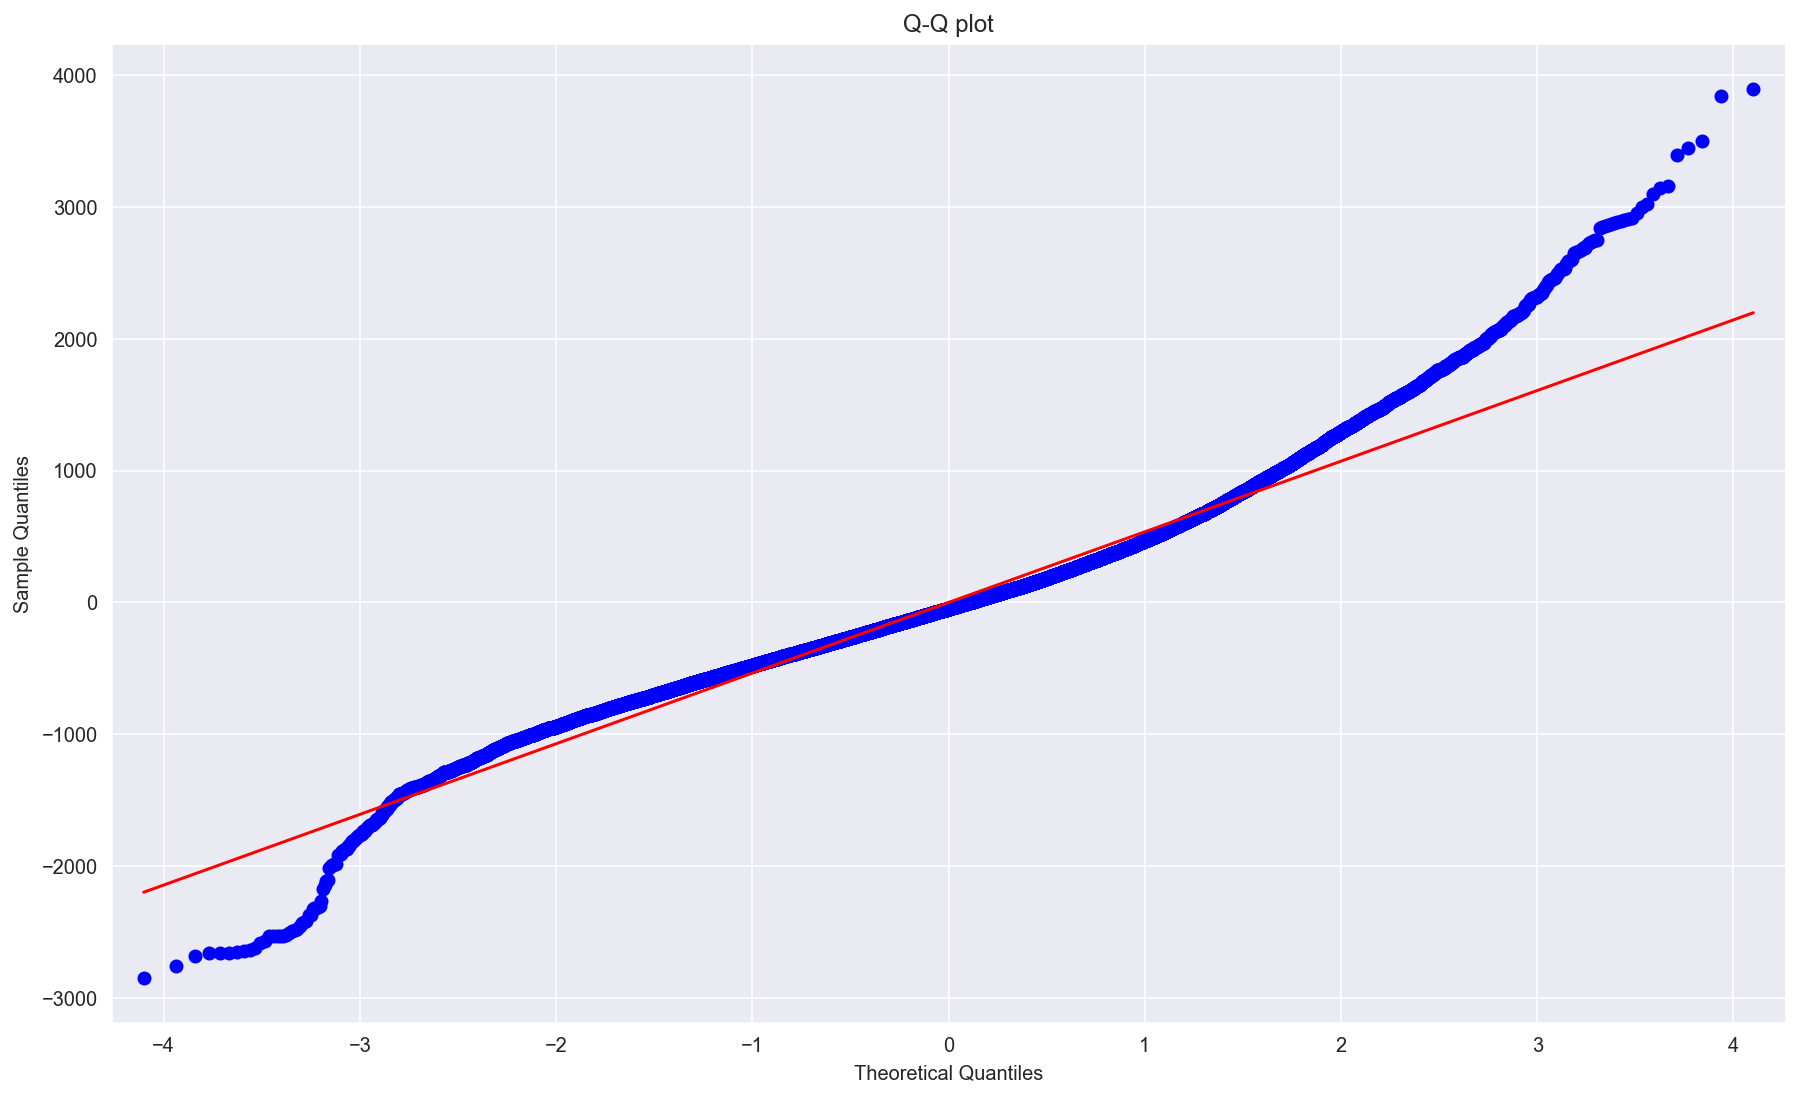

In [750]:
normality_of_residuals_test(lin_reg)

El patrón de desviaciones es en forma de S lo que implica una curtosis excesiva de los residuos. Los residuos no siguen una distribución normal.

In [277]:
homoscedasticity_test(model_st)


 Breusch-Pagan test ----
                                     value
Lagrange multiplier statistic  1988.978235
p-value                           0.000000
f-value                          57.463565
f p-value                         0.000000

 Goldfeld-Quandt test ----
                value
F statistic  0.979699
p-value      0.948608

 Residuals plots ----
